<a href="https://colab.research.google.com/github/furibeguerra/procesamiento_lenguaje_natural_2025B3/blob/main/Desafio_2_1_Fabian_Uribe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


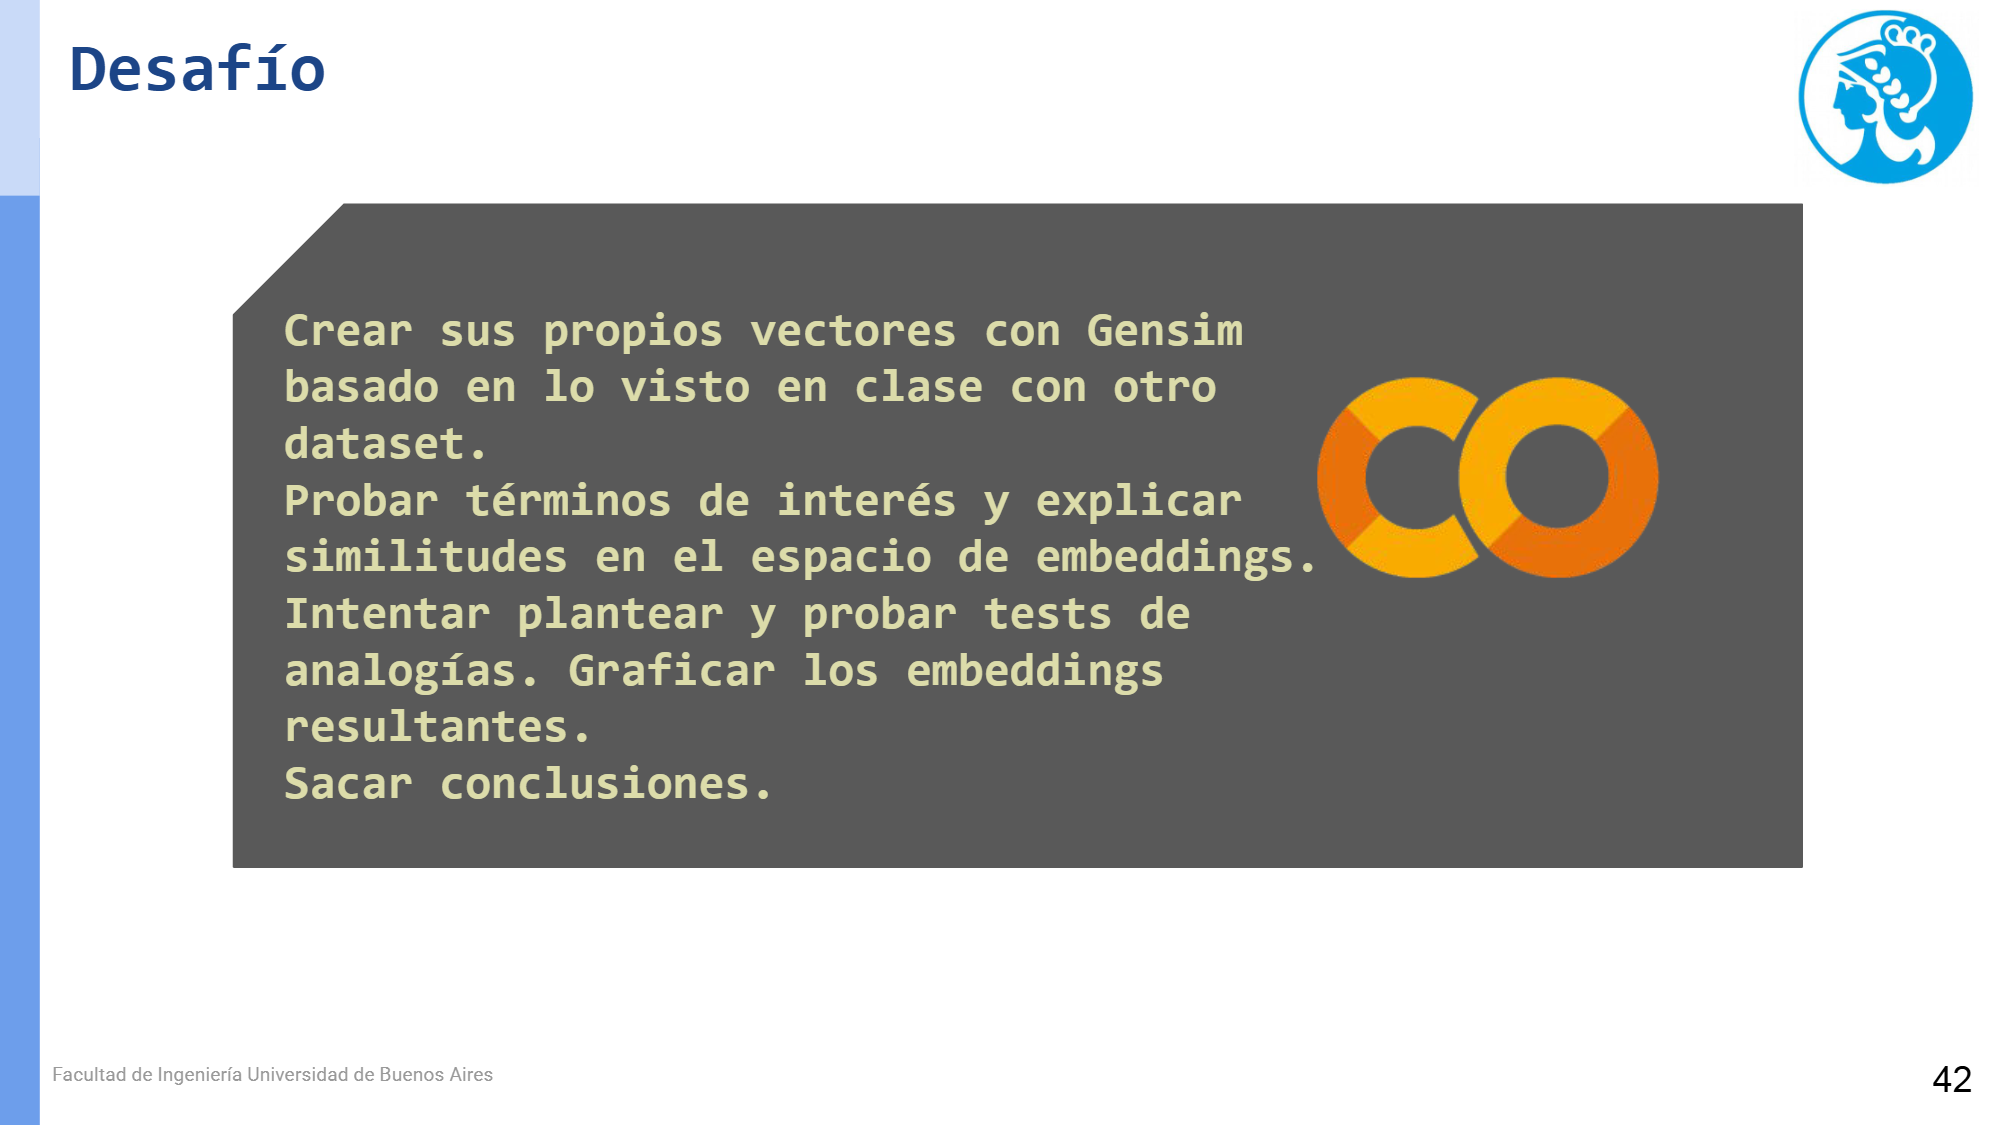


**Librerias**

In [23]:
%pip install keras

In [30]:
!pip install gensim

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from gensim.models import Word2Vec

import re
from time import time
import spacy

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

# Datos

In [21]:
import os
import platform

csv_file_path = './spam_data.csv'
github_url = 'https://raw.githubusercontent.com/furibeguerra/procesamiento_lenguaje_natural_2025B3/main/SPAM%20text%20message%2020170820%20-%20Data.csv'

if os.access(csv_file_path, os.F_OK) is False:
    print(f"Downloading {csv_file_path}...")
    if platform.system() == 'Windows':
        !curl {github_url} -o {csv_file_path}
    else:
        !wget {github_url} -O {csv_file_path}
else:
    print(f"{csv_file_path} already exists.")

./spam_data.csv already exists.


In [19]:
df = pd.read_csv('spam_data.csv', encoding='latin-1')
display(df.head())

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [31]:
df.isnull().sum()

,0
Category,0
Message,0


In [20]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 5572


In [35]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition and parser for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [37]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Message'])

In [39]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.46 mins


In [40]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(4495, 1)

In [41]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 1 - Preprocesamiento

In [44]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row.iloc[1]))

In [73]:
sentence_tokens[:5]

[['go',
  'until',
  'jurong',
  'point',
  'crazy',
  'available',
  'only',
  'in',
  'bugis',
  'n',
  'great',
  'world',
  'la',
  'e',
  'buffet',
  'cine',
  'there',
  'got',
  'amore',
  'wat'],
 ['ok', 'lar', 'joking', 'wif', 'u', 'oni'],
 ['free',
  'entry',
  'in',
  '2',
  'a',
  'wkly',
  'comp',
  'to',
  'win',
  'fa',
  'cup',
  'final',
  'tkts',
  '21st',
  'may',
  '2005',
  'text',
  'fa',
  'to',
  '87121',
  'to',
  'receive',
  'entry',
  'question',
  'std',
  'txt',
  'rate',
  't',
  "c's",
  'apply',
  "08452810075over18's"],
 ['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say'],
 ['nah',
  'i',
  "don't",
  'think',
  'he',
  'goes',
  'to',
  'usf',
  'he',
  'lives',
  'around',
  'here',
  'though']]

# 2. Crear los vectores (word2vec)

In [46]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [47]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [48]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)

In [49]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 5572


In [50]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 1940


# 3. Entrenar embeddings

In [51]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 880311.8125
Loss after epoch 1: 591546.1875
Loss after epoch 2: 556056.375
Loss after epoch 3: 477808.125
Loss after epoch 4: 462877.25
Loss after epoch 5: 453835.0
Loss after epoch 6: 446993.5
Loss after epoch 7: 432352.75
Loss after epoch 8: 406283.0
Loss after epoch 9: 401456.0
Loss after epoch 10: 397447.0
Loss after epoch 11: 394935.5
Loss after epoch 12: 390085.0
Loss after epoch 13: 386394.5
Loss after epoch 14: 382038.0
Loss after epoch 15: 379092.0
Loss after epoch 16: 377797.0
Loss after epoch 17: 376381.0
Loss after epoch 18: 366533.0
Loss after epoch 19: 354988.0


(1197748, 1770480)

# 4. Ensayar

In [64]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["free"], topn=10)

[('unlimited', 0.6336134076118469),
 ('phones', 0.6307816505432129),
 ('super', 0.6235389709472656),
 ('bluetooth', 0.607348620891571),
 ('inclusive', 0.5968935489654541),
 ('camcorder', 0.5926367044448853),
 ('sonyericsson', 0.5918998718261719),
 ('100', 0.5908170938491821),
 ('polyphonic', 0.5882168412208557),
 ('camera', 0.5875865817070007)]

Es interesante notar que la mayoria de mensajes de texto asociados con el termino "Free"inlcuian objetos relaciondos con dispositivos electronicos (Camara, telefono, sonyericcson ...) lo cual es esperado ya que es una forma facil de captar el interes de la victima.

In [63]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["think"], topn=10)

[('mean', 0.7169464230537415),
 ('ugh', 0.6984912157058716),
 ('nah', 0.6921571493148804),
 ('thinking', 0.6860148906707764),
 ('wonder', 0.6831165552139282),
 ('wow', 0.6810928583145142),
 ('ym', 0.6810598969459534),
 ('thinkin', 0.6762121319770813),
 ('move', 0.6745766401290894),
 ('barely', 0.6722310781478882)]

In [62]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["prize"], topn=10)

[('amp', -0.04270514100790024),
 ("it's", -0.05381987988948822),
 ('ã\x9c', -0.05407096818089485),
 ('til', -0.07062486559152603),
 ('pa', -0.07978624850511551),
 ('true', -0.08256242424249649),
 ('ã¼', -0.08803729712963104),
 ('lar', -0.08912022411823273),
 ('wif', -0.10156060010194778),
 ('wait', -0.10671727359294891)]

Para "Prize" si no se encontro una similaridad apropiada a mi parecer. PEro esto se puede explicar por la estructura de los msj de texto que parecen con errores tipograficos.

In [56]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["available"], topn=5)

[("aren't", 0.7715917825698853),
 ('fb', 0.7504104971885681),
 ('road', 0.7469996213912964),
 ('qatar', 0.7324878573417664),
 ('thursday', 0.7294992804527283)]

In [58]:
# Ensayar con una palabra que no está en el vocabulario:
w2v_model.wv.most_similar(negative=["four"])

KeyError: "Key 'four' not present in vocabulary"

In [66]:
# el método `get_vector` permite obtener los vectores:
vector_free = w2v_model.wv.get_vector("free")
print(vector_free)

[-0.30620745  0.16481034 -0.06198534  0.02942982 -0.2811505   0.18295595
  0.28534982 -0.03321683 -0.04037622  0.09851476  0.02322391  0.3907077
 -0.28422254 -0.13259877  0.25994256 -0.04460635  0.2041681   0.07725768
  0.17484123  0.19027391  0.3658934   0.28167346 -0.06044817 -0.06209482
  0.05574848 -0.09583297 -0.2714898   0.2721596   0.24903424 -0.16830401
  0.03881067 -0.35004404 -0.19616498  0.3721312  -0.24104859 -0.39978698
  0.21473698  0.16331288 -0.3528304   0.09695072 -0.14415042  0.1706272
 -0.15206768 -0.05952388 -0.10628846  0.11034719  0.20182379  0.36437514
 -0.20739798 -0.48874334  0.11180273  0.20050749 -0.25736398  0.06104927
 -0.07147264  0.06207976  0.28435287  0.26250824  0.10513142 -0.10618784
 -0.32964718 -0.26376283  0.23351447 -0.5082778  -0.13996685 -0.04654547
 -0.04574092  0.06310614 -0.21711352 -0.08772284  0.38214386  0.04521381
 -0.43682867 -0.19348414 -0.0936623  -0.29408205  0.0497976   0.2537227
 -0.13745491  0.31889674 -0.06939798 -0.16420643 -0.10

In [67]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_free)

[('free', 1.0000001192092896),
 ('unlimited', 0.6336134076118469),
 ('phones', 0.6307817101478577),
 ('super', 0.6235390305519104),
 ('bluetooth', 0.6073487401008606),
 ('inclusive', 0.5968936085700989),
 ('camcorder', 0.59263676404953),
 ('sonyericsson', 0.5918998718261719),
 ('100', 0.5908170938491821),
 ('polyphonic', 0.5882168412208557)]

In [68]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["free"], topn=10)

[('unlimited', 0.6336134076118469),
 ('phones', 0.6307816505432129),
 ('super', 0.6235389709472656),
 ('bluetooth', 0.607348620891571),
 ('inclusive', 0.5968935489654541),
 ('camcorder', 0.5926367044448853),
 ('sonyericsson', 0.5918998718261719),
 ('100', 0.5908170938491821),
 ('polyphonic', 0.5882168412208557),
 ('camera', 0.5875865817070007)]

# 5. Visualizar agrupación de vectores

In [69]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [70]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab") # esto para plotly en colab

In [71]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.show(renderer="colab") # esto para plotly en colab

In [72]:
vectors = np.asarray(w2v_model.wv.vectors)
labels = list(w2v_model.wv.index_to_key)

np.savetxt("vectors.tsv", vectors, delimiter="\t")

with open("labels.tsv", "w") as fp:
    for item in labels:
        fp.write("%s\n" % item)

**1. Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset. (Done)**

Para el desarrollo de este ejercicio he tomado el dataset disponible en https://www.kaggle.com/datasets/team-ai/spam-text-message-classification
El Dataset contiene mensajes categorizados como Spam (malos) o Ham (buenos).


**2. Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias)**

Para el desarrollo del ejercicio probamos los siguientes terminos:
Prize
available
free
think

Los comentarios se encuentran debajo de cada test para las palabras con mayor relevancia.


3. Graficarlos. (Done- referirse a la seccion 5)

**Obtener conclusiones**

En general se realizó el mismo ejercicios que el propuesto en clase para un conjunto de datos relacionados con un mix de mensajes de texto que estaban clasificados como spam/ham. El principal problema que se encontro es que muchos de los mensajes contenian errores tipograficos, lo cual es esperado debido a la naturaleza del mismo. Por este motivo, al vectorizar la palabra "Prize" no fue posible obtener resultados asociados que tuvieran sentido. Por su parte, al evaluar la palabra "Free" se encontró una relación directa con dispositvios electronicos lo cual puede ser un buen punto de partida para desarrollar modelos de clasificacion de spam con los vectores asociados a "Free"
